#Churn prediction models

## Importing packages

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [ ]:
import tensorflow as tf
from keras import backend as K

In [ ]:
#Importing classifiers and help functions (params search, evaluation)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import metrics as m
from sklearn import metrics
from sklearn.metrics import (
    average_precision_score, f1_score,
    precision_recall_curve,
    roc_auc_score,accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix)


In [ ]:
import joblib
from os import makedirs

In [ ]:
#TO DELETE
makedirs('/content/gdrive/My Drive/fastai/bank_churn/femodels8')

In [ ]:
#TO DELETE
!ls '/content/gdrive/My Drive/fastai/bank_churn/femodels8'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai/'
path_cr = Path(base_dir + 'bank_churn')
#path_cr.mkdir(parents=True, exist_ok=True)

Mounted at /content/gdrive


In [ ]:
#TO RENAME THE FILE
#Reading the data 
data = pd.read_csv(path_cr/'preprocessed2.csv')


#to delete
fe_data = pd.read_csv(path_cr/'fedata.csv')
#opening dataset with 3 additional features added in the FE section below
#fe_data = pd.read_csv(path_cr/'fe_data.csv')




## Exploring and preprocessing data

In [ ]:
data = pd.read_csv(path_cr/'datasets_66163_130012_Churn_Modelling.csv')
print(data.shape)
data.sample(5)

In [ ]:
#Checking for missing values
data.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [ ]:
#Checking data types
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [ ]:
#Checking unique values
for i in data.columns:
  print(i)
  print(data[i].unique())

RowNumber
[    1     2     3     4 ...  9997  9998  9999 10000]
CustomerId
[15634602 15647311 15619304 15701354 ... 15569892 15584532 15682355 15628319]
Surname
['Hargrave' 'Hill' 'Onio' 'Boni' ... 'Cleveland' 'Kashiwagi' 'Aldridge' 'Burbidge']
CreditScore
[619 608 502 699 ... 412 382 373 419]
Geography
['France' 'Spain' 'Germany']
Gender
['Female' 'Male']
Age
[42 41 39 43 ... 78 81 92 83]
Tenure
[ 2  1  8  7  4  6  3 10  5  9  0]
Balance
[     0.    83807.86 159660.8  125510.82 ... 155060.41  57369.61  75075.31 130142.79]
NumOfProducts
[1 3 2 4]
HasCrCard
[1 0]
IsActiveMember
[1 0]
EstimatedSalary
[101348.88 112542.58 113931.57  93826.63 ... 101699.77  42085.58  92888.52  38190.78]
Exited
[1 0]


In [ ]:
#Dropping useless columns
df = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3119,680,Germany,Female,51,5,143139.87,1,0,0,47795.43,1
8809,593,Germany,Female,38,5,142658.04,2,0,1,135337.11,0
3205,850,France,Female,42,8,0.00,1,1,0,19632.64,1
3727,781,France,Female,27,7,186558.55,1,1,1,175071.29,1
4799,551,France,Male,52,1,0.00,1,0,0,63584.55,1


In [ ]:
#Checking amounts of churners and non-churners
print(df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count())

2037 7963


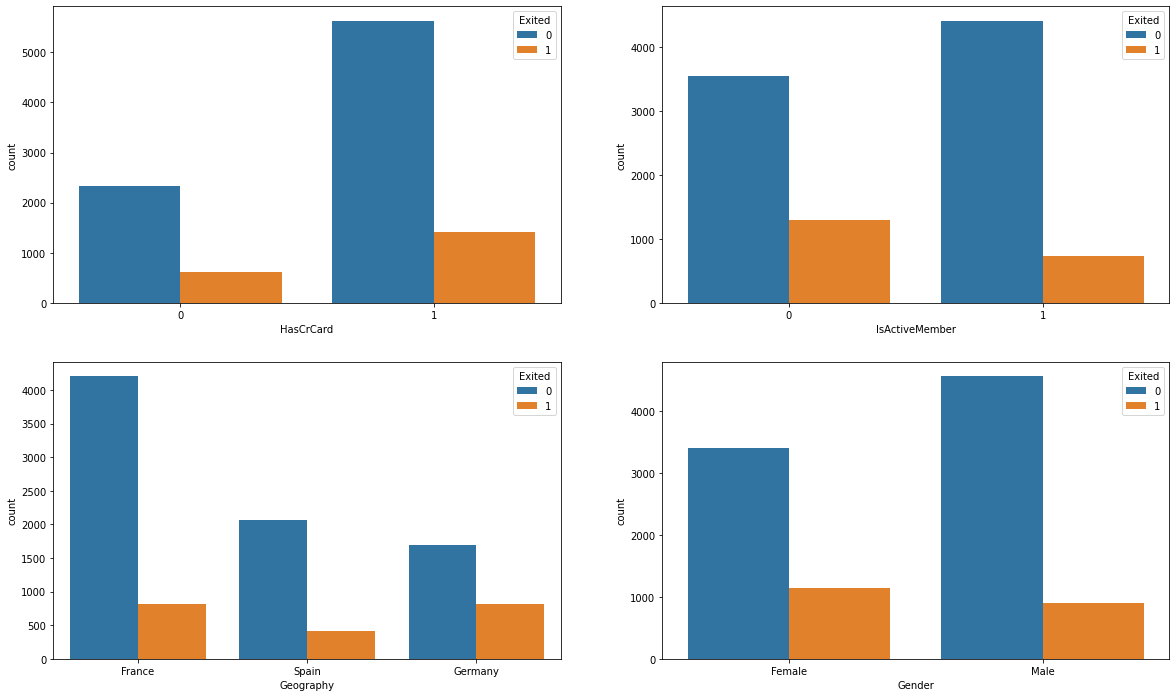

In [ ]:
#Exploring categorical values for churners and non-churners
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[1][1])

Female, German, non-active members have higher likelihood to churn.

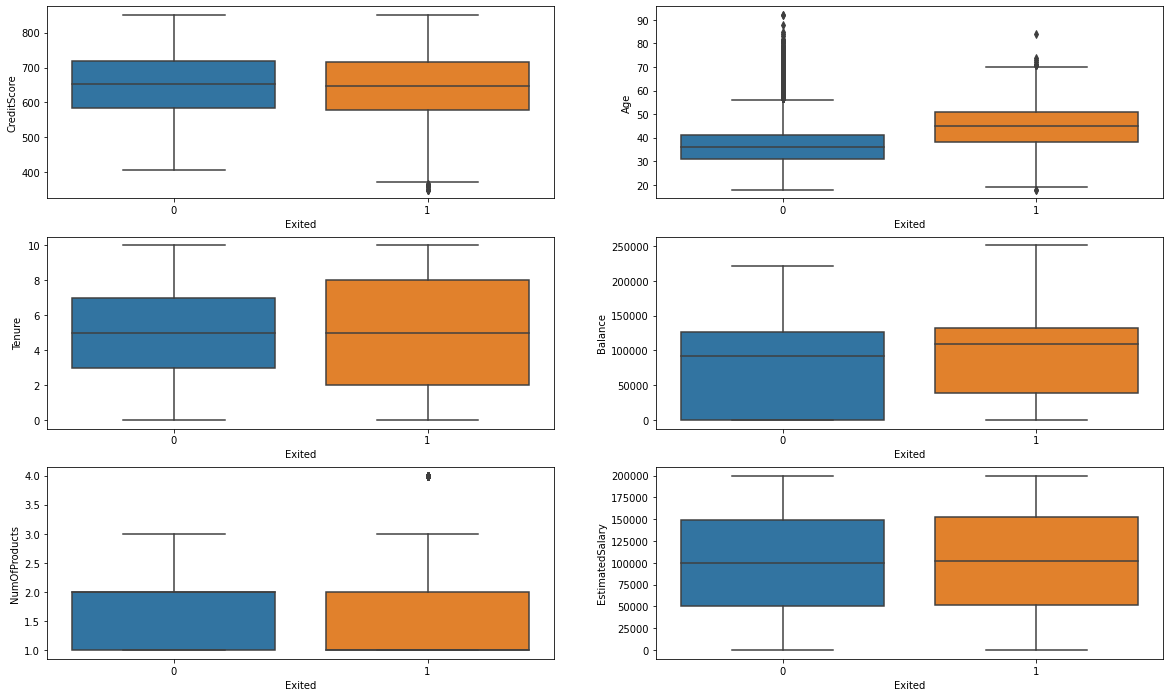

In [ ]:
#Exploring continuous values for churners and non-churners
#fig, ax= plt.subplots(figsize=(10, 8)) 
fig, ax = plt.subplots(3, 2, figsize=(20, 12))

sns.boxplot(x = df['Exited'], y = df['CreditScore'], ax=ax[0][0])
sns.boxplot(x = df['Exited'], y = df['Age'], ax=ax[0][1])
sns.boxplot(x = df['Exited'], y = df['Tenure'], ax=ax[1][0])
sns.boxplot(x = df['Exited'], y = df['Balance'], ax=ax[1][1])
sns.boxplot(x = df['Exited'], y = df['NumOfProducts'], ax=ax[2][0])
sns.boxplot(x = df['Exited'], y = df['EstimatedSalary'], ax=ax[2][1])

  
plt.show() 

Elder clients show higher likelihood to churn. 
Clients with lower balance are less likely to churn.

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [ ]:
#converting categorical to binary cols
dummy_fields = ['Geography', 'Gender']
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([dummies, df], axis=1)

data_w_dummies = df.drop(dummy_fields, axis=1)
data_w_dummies.sample()

,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5986,1,0,0,0,1,527,35,8,0.0,1,1,0,98031.53,1


In [ ]:
data_w_dummies.shape

(10000, 14)

In [ ]:
#Saving preprocessed data to csv
data_for_model = data_w_dummies.to_csv(path_cr/'preprocessed2.csv', index=False)

##Creating additional features

In [ ]:
fe_data = data.copy()
fe_data.shape

(10000, 14)

In the previous section we noted that elder customers, female customers, non-active customers and customers from Germany are more likely to churn. Let's create additional features based on them. For the age we'll determine it based on churners' median age.

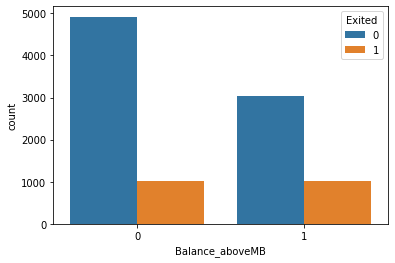

In [ ]:
median_balance = fe_data.loc[(fe_data.Exited == 1),'Balance'].median()
fe_data['Balance_aboveMB'] = 0
fe_data.loc[(fe_data['Balance']>median_balance), 'Balance_aboveMB']=1
sns.countplot(x='Balance_aboveMB', hue = 'Exited',data = fe_data)

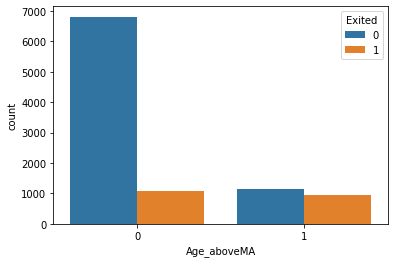

In [ ]:
median_age = fe_data.loc[(fe_data.Exited == 1),'Age'].median()
fe_data['Age_aboveMA'] = 0
fe_data.loc[(fe_data['Age']>median_age), 'Age_aboveMA']=1
sns.countplot(x='Age_aboveMA', hue = 'Exited',data = fe_data)

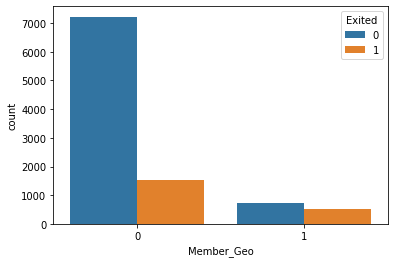

In [ ]:
fe_data['Member_Geo'] = 0
fe_data.loc[(fe_data['Geography_Germany']==1) & (fe_data['IsActiveMember'] == 0), 'Member_Geo']=1
sns.countplot(x='Member_Geo', hue = 'Exited',data = fe_data)

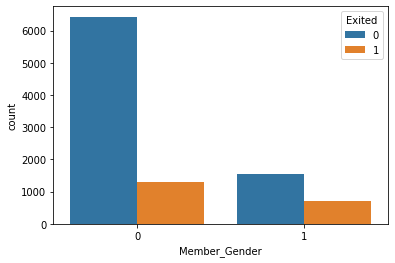

In [ ]:
fe_data['Member_Gender'] = 0
fe_data.loc[(fe_data['Gender_Female']==1) & (fe_data['IsActiveMember'] == 0), 'Member_Gender']=1
sns.countplot(x='Member_Gender', hue = 'Exited',data = fe_data)

In [ ]:
fedata = fe_data.to_csv(path_cr/'fedata.csv', index=False)

##Splitting and scaling data, defining class weights

In [ ]:
#Splitting data
y = fe_data.Exited.values
x = fe_data.drop('Exited', axis = 1)
#Scaling data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
x = sc.fit_transform(x)

In [ ]:
#splitting into training, test and val datasets
from sklearn.model_selection import train_test_split
x_train, x_t, y_train, y_t = train_test_split(x, y, test_size = .2, random_state = 28)
x_test, x_val, y_test, y_val = train_test_split(x_t, y_t, test_size = 0.5, random_state = 28)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(8000, 17) (8000,) (1000, 17) (1000,) (1000, 17) (1000,)


In [ ]:
#Defining set of sample weights
sw = []
name = 'sample_weights'
for i in np.arange(2.2, 6.8, 0.1):
  namei = name + str(i)
  namei = np.array([1.0]*y_train.shape[0])
  namei[y_train==1] = i
  namei[y_train==0] = 1
  sw.append(namei)

In [ ]:
#Defining the functions to evaluate models 
def evaluate_model(model_name):
  preds_t = model_name.predict(x_test)
  preds_v = model_name.predict(x_val)
  tnt, fpt, fnt, tpt = confusion_matrix(y_test, preds_t).ravel()
  tn, fp, fn, tp = confusion_matrix(y_val, preds_v).ravel()
  
  print('Test set')
  print(classification_report(y_test, preds_t))
  print('tn, fp, fn, tp: ',tnt, fpt, fnt, tpt)    
  print('Val set')
  print(classification_report(y_val, preds_v))
  print('tn, fp, fn, tp: ', tn, fp, fn, tp)

def confusion_matrix_show_test(modelname):
  plot_confusion_matrix(modelname, x_test, y_test, labels=[0,1], normalize='true')

def confusion_matrix_show_val(modelname):
  plot_confusion_matrix(modelname, x_val, y_val, labels=[0,1], normalize='true')

def feature_importance_show_xgb(model_name, features):
  model_name.get_booster().feature_names = features
  xgb.plot_importance(model_name.get_booster())

##Naive Bayes

In [ ]:
bayesgaus = GaussianNB()
bayesgaus.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
evaluate_model(bayesgaus)

Test set
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       818
           1       0.44      0.59      0.51       182

    accuracy                           0.79      1000
   macro avg       0.67      0.71      0.69      1000
weighted avg       0.82      0.79      0.80      1000

tn, fp, fn, tp:  681 137 74 108
Val set
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       792
           1       0.42      0.53      0.47       208

    accuracy                           0.75      1000
   macro avg       0.64      0.67      0.65      1000
weighted avg       0.77      0.75      0.76      1000

tn, fp, fn, tp:  640 152 98 110


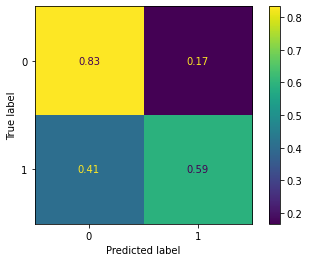

In [ ]:
plot_confusion_matrix(bayesgaus, x_test, y_test, labels=[0,1], normalize='true')

In [ ]:
#with sample weights (6.2)
bayesgaus_sw62 = GaussianNB()
bayesgaus_sw62.fit(x_train, y_train, sample_weight=sw[10])

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
evaluate_model(bayesgaus_sw62)

Test set
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       818
           1       0.39      0.73      0.51       182

    accuracy                           0.74      1000
   macro avg       0.66      0.74      0.67      1000
weighted avg       0.83      0.74      0.77      1000

tn, fp, fn, tp:  610 208 50 132
Val set
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       792
           1       0.39      0.63      0.48       208

    accuracy                           0.72      1000
   macro avg       0.64      0.69      0.64      1000
weighted avg       0.78      0.72      0.74      1000

tn, fp, fn, tp:  586 206 76 132


In [ ]:
joblib.dump(bayesgaus_sw62,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/bayesgaus_sw62.sav')

In [ ]:
bayesgaus_sw43_l = joblib.load('/content/gdrive/My Drive/fastai/bank_churn/models/bayesgaus_sw43.sav')
result = bayesgaus_sw43_l.score(x_test, y_test)

##Random forest 




In [ ]:
ferf_cw3 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0:1,1:3},
                            criterion='gini', max_depth=8, max_features=9,
                            max_leaf_nodes=None, max_samples=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=7,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_jobs=None, oob_score=False, random_state=28,
                            verbose=0, warm_start=False)
ferf_cw3.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [ ]:
evaluate_model(ferf_cw3)

Test set
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       818
           1       0.56      0.68      0.61       182

    accuracy                           0.84      1000
   macro avg       0.74      0.78      0.76      1000
weighted avg       0.86      0.84      0.85      1000

tn, fp, fn, tp:  720 98 58 124
Val set
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       792
           1       0.57      0.63      0.60       208

    accuracy                           0.82      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.83      0.82      0.83      1000

tn, fp, fn, tp:  693 99 76 132


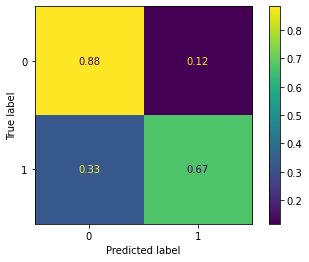

In [ ]:
confusion_matrix_show_val(ferf_cw3)

In [ ]:
joblib.dump(ferf_cw3,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw3.sav')

['/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw3.sav']

In [ ]:
#with class weights 1, 4
ferf_cw4 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 4},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_cw4.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 4},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [ ]:
evaluate_model(ferf_cw4)

Test set
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       818
           1       0.51      0.74      0.60       182

    accuracy                           0.82      1000
   macro avg       0.72      0.79      0.74      1000
weighted avg       0.86      0.82      0.83      1000

tn, fp, fn, tp:  688 130 48 134
Val set
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       792
           1       0.54      0.70      0.61       208

    accuracy                           0.81      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.84      0.81      0.82      1000

tn, fp, fn, tp:  667 125 63 145


In [ ]:
joblib.dump(ferf_cw4,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw4.sav')

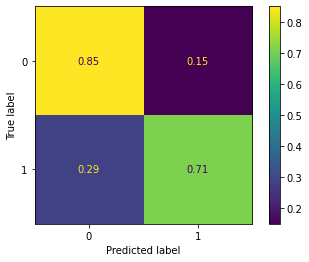

In [ ]:
confusion_matrix_show_test(ferf_cw4)

In [ ]:
ferf_cw4_sw36 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 4},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_cw4_sw36.fit(x_train, y_train,sample_weight=sw[14])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 4},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [ ]:
joblib.dump(ferf_cw4_sw36,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw4_sw36.sav')

['/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw4_sw36.sav']

In [ ]:
evaluate_model(ferf_cw4_sw36)

Test set
              precision    recall  f1-score   support

           0       0.97      0.57      0.72       818
           1       0.32      0.91      0.47       182

    accuracy                           0.64      1000
   macro avg       0.64      0.74      0.60      1000
weighted avg       0.85      0.64      0.68      1000

tn, fp, fn, tp:  470 348 17 165
Val set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       792
           1       0.37      0.87      0.52       208

    accuracy                           0.66      1000
   macro avg       0.66      0.74      0.63      1000
weighted avg       0.83      0.66      0.70      1000

tn, fp, fn, tp:  483 309 27 181


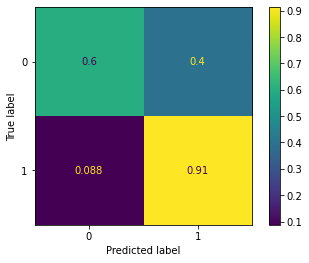

In [ ]:
confusion_matrix_show_test(ferf_cw4_sw36)

In [ ]:
ferf_cw55_sw42 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 5.5},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_cw55_sw42.fit(x_train, y_train,sample_weight=sw[20])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 5.5}, criterion='gini',
                       max_depth=8, max_features=9, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=28, verbose=0, warm_start=False)

In [ ]:
joblib.dump(ferf_cw55_sw42,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw55_sw42.sav')

['/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw55_sw42.sav']

In [ ]:
evaluate_model(ferf_cw55_sw42)

Test set
              precision    recall  f1-score   support

           0       0.97      0.46      0.63       818
           1       0.28      0.93      0.43       182

    accuracy                           0.55      1000
   macro avg       0.62      0.70      0.53      1000
weighted avg       0.84      0.55      0.59      1000

tn, fp, fn, tp:  380 438 13 169
Val set
              precision    recall  f1-score   support

           0       0.95      0.51      0.66       792
           1       0.33      0.91      0.48       208

    accuracy                           0.59      1000
   macro avg       0.64      0.71      0.57      1000
weighted avg       0.82      0.59      0.62      1000

tn, fp, fn, tp:  400 392 19 189


In [ ]:
ferf_cw39_sw25 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3.9},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_cw39_sw25.fit(x_train, y_train,sample_weight=sw[3])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 3.9}, criterion='gini',
                       max_depth=8, max_features=9, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=28, verbose=0, warm_start=False)

In [ ]:
evaluate_model(ferf_cw39_sw25)

Test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.79       818
           1       0.38      0.87      0.52       182

    accuracy                           0.71      1000
   macro avg       0.67      0.77      0.66      1000
weighted avg       0.85      0.71      0.75      1000

tn, fp, fn, tp:  555 263 24 158
Val set
              precision    recall  f1-score   support

           0       0.94      0.68      0.79       792
           1       0.41      0.84      0.55       208

    accuracy                           0.71      1000
   macro avg       0.67      0.76      0.67      1000
weighted avg       0.83      0.71      0.74      1000

tn, fp, fn, tp:  540 252 34 174


In [ ]:
joblib.dump(ferf_cw39_sw25,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw39_sw25.sav')

['/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw39_sw25.sav']

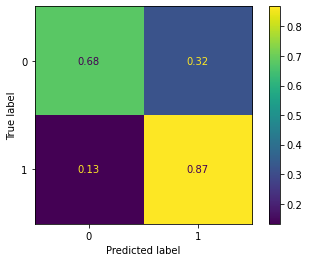

In [ ]:
confusion_matrix_show_test(ferf_cw39_sw25)

In [ ]:
#grid search for the best parameters for the dataset with additional features, v.1
par_grid = {'max_depth': [3, 5, 6, 7, 8,12], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7,9,13]}
rf_grid = GridSearchCV(RandomForestClassifier(), par_grid, cv=5, refit=True, verbose=0)
rf_grid.fit(x_train, y_train)
print(rf_grid.best_estimator_)
print(rf_grid.best_params_)
print(rf_grid.best_score_)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'max_depth': 8, 'max_features': 9, 'min_samples_split': 13, 'n_estimators': 100}
0.8681428571428571


In [ ]:
ferf_mss13 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, 
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_mss13.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [ ]:
evaluate_model(ferf_mss13)

Test set
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       818
           1       0.70      0.45      0.55       182

    accuracy                           0.86      1000
   macro avg       0.80      0.70      0.73      1000
weighted avg       0.85      0.86      0.85      1000

tn, fp, fn, tp:  784 34 101 81
Val set
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       792
           1       0.81      0.39      0.53       208

    accuracy                           0.85      1000
   macro avg       0.84      0.69      0.72      1000
weighted avg       0.85      0.85      0.83      1000

tn, fp, fn, tp:  773 19 126 82


In [ ]:
joblib.dump(ferf_mss13,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_mss13.sav')

['/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_mss13.sav']

In [ ]:
#with class and sample weights 1, 4 & 3,6
ferf_cw4_sw36__mss13 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0:1, 1:4},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_cw4_sw36__mss13.fit(x_train, y_train, sample_weight=sw[14])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 4},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [ ]:
evaluate_model(ferf_cw4_sw36__mss13)

Test set
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       818
           1       0.32      0.91      0.47       182

    accuracy                           0.62      1000
   macro avg       0.64      0.74      0.59      1000
weighted avg       0.85      0.62      0.67      1000

tn, fp, fn, tp:  459 359 16 166
Val set
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       792
           1       0.37      0.88      0.52       208

    accuracy                           0.67      1000
   macro avg       0.66      0.74      0.63      1000
weighted avg       0.83      0.67      0.70      1000

tn, fp, fn, tp:  484 308 26 182


In [ ]:
joblib.dump(ferf_cw4_sw36__mss13,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_cw4_sw36__mss13.sav')

In [ ]:
#grid search params for data with additional features, sample weights 1, 6.2, w/o class weights (6.2 - tp & tn were 73-88%)
ferf_sw62_mss13 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, 
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28,
                       verbose=0, warm_start=False)
ferf_sw62_mss13.fit(x_train, y_train, sample_weight=sw[40])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=28, verbose=0,
                       warm_start=False)

In [ ]:
evaluate_model(ferf_sw62_mss13)

Test set
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       818
           1       0.43      0.82      0.57       182

    accuracy                           0.77      1000
   macro avg       0.69      0.79      0.70      1000
weighted avg       0.86      0.77      0.79      1000

tn, fp, fn, tp:  620 198 32 150
Val set
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       792
           1       0.47      0.78      0.59       208

    accuracy                           0.77      1000
   macro avg       0.70      0.77      0.71      1000
weighted avg       0.83      0.77      0.79      1000

tn, fp, fn, tp:  606 186 45 163


In [ ]:
joblib.dump(ferf_sw62_mss13,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/ferf_sw62_mss13.sav')

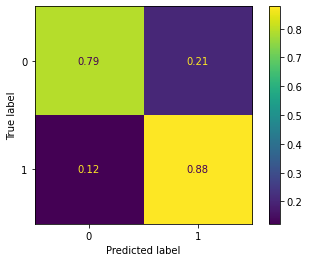

In [ ]:
confusion_matrix_show_test(ferf_sw62_mss13)

##XGB

In [ ]:
xgbfe = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1)
xgbfe.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=1, verbosity=1)

In [ ]:
joblib.dump(xgbfe,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe.sav')

In [ ]:
evaluate_model(xgbfe)

Test set
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       818
           1       0.71      0.49      0.58       182

    accuracy                           0.87      1000
   macro avg       0.80      0.72      0.75      1000
weighted avg       0.86      0.87      0.86      1000

tn, fp, fn, tp:  781 37 92 90
Val set
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       792
           1       0.78      0.41      0.54       208

    accuracy                           0.85      1000
   macro avg       0.82      0.69      0.73      1000
weighted avg       0.85      0.85      0.84      1000

tn, fp, fn, tp:  768 24 122 86


In [ ]:
xgbfe_ss06_sw44 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=0.6)
xgbfe_ss06_sw44.fit(x_train, y_train, sample_weight=sw[22])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
evaluate_model(xgbfe_ss06_sw44)

Test set
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       818
           1       0.47      0.80      0.59       182

    accuracy                           0.80      1000
   macro avg       0.71      0.80      0.73      1000
weighted avg       0.86      0.80      0.82      1000

tn, fp, fn, tp:  654 164 37 145
Val set
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       792
           1       0.48      0.73      0.58       208

    accuracy                           0.78      1000
   macro avg       0.70      0.76      0.71      1000
weighted avg       0.83      0.78      0.79      1000

tn, fp, fn, tp:  626 166 56 152


In [ ]:
joblib.dump(xgbfe_ss06_sw44,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe_ss06_sw44.sav')

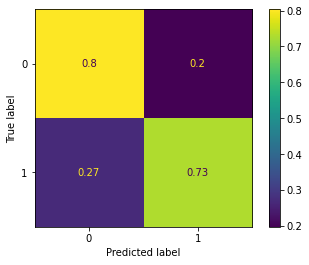

In [ ]:
confusion_matrix_show_val(xgbfe_ss06_sw42)

In [ ]:
#60 estimators, sample weights 3.6, scale_pos_weight 3.9
xgbfe60_ss06_spw39_sw36 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=60,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=3.9, seed=0, silent=True, subsample=0.6)
xgbfe60_ss06_spw39_sw36.fit(x_train, y_train, sample_weight=sw[14])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.9, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
joblib.dump(xgbfe60_ss06_spw39_sw36,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe60_ss06_spw39_sw36.sav')

['/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe60_ss06_spw39_sw36.sav']

In [ ]:
evaluate_model(xgbfe60_ss06_spw39_sw36)

Test set
              precision    recall  f1-score   support

           0       0.96      0.62      0.76       818
           1       0.34      0.89      0.50       182

    accuracy                           0.67      1000
   macro avg       0.65      0.76      0.63      1000
weighted avg       0.85      0.67      0.71      1000

tn, fp, fn, tp:  510 308 20 162
Val set
              precision    recall  f1-score   support

           0       0.93      0.65      0.77       792
           1       0.38      0.81      0.52       208

    accuracy                           0.69      1000
   macro avg       0.66      0.73      0.64      1000
weighted avg       0.82      0.69      0.72      1000

tn, fp, fn, tp:  517 275 39 169


In [ ]:
#60 estimators, sample weights 3.6, scale_pos_weight 3.7, min_child_weight 5
xgbfe60_ss06_mcw5_spw37_sw36 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=60,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=3.7, seed=0, silent=True, subsample=0.6)
xgbfe60_ss06_mcw5_spw37_sw36.fit(x_train, y_train, sample_weight=sw[14])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.7, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
joblib.dump(xgbfe60_ss06_mcw5_spw37_sw36,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe60_ss06_mcw5_spw37_sw36.sav')

In [ ]:
evaluate_model(xgbfe60_ss06_mcw5_spw37_sw36)

Test set
              precision    recall  f1-score   support

           0       0.96      0.63      0.76       818
           1       0.35      0.88      0.50       182

    accuracy                           0.68      1000
   macro avg       0.66      0.76      0.63      1000
weighted avg       0.85      0.68      0.72      1000

tn, fp, fn, tp:  518 300 21 161
Val set
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       792
           1       0.39      0.84      0.53       208

    accuracy                           0.69      1000
   macro avg       0.66      0.74      0.65      1000
weighted avg       0.82      0.69      0.72      1000

tn, fp, fn, tp:  517 275 34 174


In [ ]:
#with sample weights 1, 4.5
xgbfe_ss06_spw17_sw46 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1.7, seed=0, silent=True, subsample=0.6)
xgbfe_ss06_spw17_sw46.fit(x_train, y_train, sample_weight=sw[24])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.7, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
joblib.dump(xgbfe_ss06_spw17_sw46,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe_ss06_spw17_sw46.sav')

In [ ]:
evaluate_model(xgbfe_ss06_spw17_sw46)

Test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.79       818
           1       0.37      0.87      0.52       182

    accuracy                           0.71      1000
   macro avg       0.67      0.77      0.66      1000
weighted avg       0.85      0.71      0.74      1000

tn, fp, fn, tp:  553 265 24 158
Val set
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       792
           1       0.40      0.79      0.53       208

    accuracy                           0.71      1000
   macro avg       0.66      0.74      0.66      1000
weighted avg       0.82      0.71      0.74      1000

tn, fp, fn, tp:  545 247 43 165


In [ ]:
#40 estimators, scale pos weight 5.2
xgbfe40_ss06_spw52 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=40,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=5.2, seed=0, silent=True, subsample=0.6)
xgbfe40_ss06_spw52.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.2, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
evaluate_model(xgbfe40_ss06_spw52)

Test set
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       818
           1       0.44      0.78      0.56       182

    accuracy                           0.78      1000
   macro avg       0.69      0.78      0.71      1000
weighted avg       0.85      0.78      0.80      1000

tn, fp, fn, tp:  636 182 40 142
Val set
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       792
           1       0.47      0.75      0.57       208

    accuracy                           0.77      1000
   macro avg       0.69      0.76      0.71      1000
weighted avg       0.83      0.77      0.79      1000

tn, fp, fn, tp:  615 177 53 155


In [ ]:
joblib.dump(xgbfe40_ss06_spw52,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe40_ss06_spw52.sav')

In [ ]:
xgbfe30_ss06_spw62 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=30,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=6.2, seed=0, silent=True, subsample=0.6)
xgbfe30_ss06_spw62.fit(x_train, y_train)#,sample_weight=class_weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.2, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
evaluate_model(xgbfe30_ss06_spw62)

Test set
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       820
           1       0.40      0.78      0.53       180

    accuracy                           0.75      1000
   macro avg       0.67      0.76      0.68      1000
weighted avg       0.84      0.75      0.78      1000

tn, fp, fn, tp:  610 210 39 141
Val set
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       810
           1       0.45      0.76      0.56       190

    accuracy                           0.78      1000
   macro avg       0.69      0.77      0.71      1000
weighted avg       0.84      0.78      0.79      1000

tn, fp, fn, tp:  632 178 46 144


In [ ]:
#40 estimators, scale pos weight 5.2, sample weight 4.6
xgbfe40_ss06_spw52_sw46 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=40,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=5.2, seed=0, silent=True, subsample=0.6)
xgbfe40_ss06_spw52_sw46.fit(x_train, y_train,sample_weight=sw[24])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.2, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
evaluate_model(xgbfe40_ss06_spw52_sw46)

Test set
              precision    recall  f1-score   support

           0       0.97      0.48      0.64       818
           1       0.29      0.93      0.44       182

    accuracy                           0.56      1000
   macro avg       0.63      0.71      0.54      1000
weighted avg       0.85      0.56      0.61      1000

tn, fp, fn, tp:  394 424 12 170
Val set
              precision    recall  f1-score   support

           0       0.95      0.51      0.66       792
           1       0.32      0.89      0.47       208

    accuracy                           0.59      1000
   macro avg       0.63      0.70      0.57      1000
weighted avg       0.82      0.59      0.62      1000

tn, fp, fn, tp:  401 391 23 185


In [ ]:
joblib.dump(xgbfe40_ss06_spw52_sw46,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe40_ss06_spw52_sw46.sav')

In [ ]:
#scale pos weight 4.5, subsample 0.6, w/o sample weights
xgbfe_ss06_spw45 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=4.5, seed=0, silent=True, subsample=0.6)
xgbfe_ss06_spw45.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.5, seed=0,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
joblib.dump(xgbfe_ss06_spw45,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgbfe_ss06_spw45.sav')

In [ ]:
evaluate_model(xgbfe_ss06_spw45)

Test set
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       818
           1       0.46      0.82      0.59       182

    accuracy                           0.80      1000
   macro avg       0.71      0.81      0.73      1000
weighted avg       0.86      0.80      0.81      1000

tn, fp, fn, tp:  645 173 32 150
Val set
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       792
           1       0.48      0.73      0.58       208

    accuracy                           0.78      1000
   macro avg       0.70      0.76      0.71      1000
weighted avg       0.83      0.78      0.79      1000

tn, fp, fn, tp:  625 167 56 152


###Further experiments

In [ ]:
#colsample by tree = 0.9, 40 estimators
xgbfe40_spw52_cst09 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=0.9, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=40,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=5.2, seed=None, silent=True, subsample=0.6)
xgbfe40_spw52_cst09.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.2, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
evaluate_model(xgbfe40_spw52_cst09)

Test set
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       818
           1       0.44      0.79      0.57       182

    accuracy                           0.78      1000
   macro avg       0.69      0.78      0.71      1000
weighted avg       0.85      0.78      0.80      1000

tn, fp, fn, tp:  635 183 38 144
Val set
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       792
           1       0.47      0.74      0.57       208

    accuracy                           0.77      1000
   macro avg       0.69      0.76      0.71      1000
weighted avg       0.82      0.77      0.79      1000

tn, fp, fn, tp:  617 175 55 153


In [ ]:
xgb100_sw42 =  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)
xgb100_sw42.fit(x_train, y_train, sample_weight=sw[20])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [ ]:
joblib.dump(xgb100_sw42,'/content/gdrive/My Drive/fastai/bank_churn/femodels8/xgb100_sw42.sav')

In [ ]:
evaluate_model(xgb100_sw42)

Test set
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       818
           1       0.48      0.77      0.59       182

    accuracy                           0.81      1000
   macro avg       0.71      0.79      0.73      1000
weighted avg       0.86      0.81      0.82      1000

tn, fp, fn, tp:  666 152 41 141
Val set
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       792
           1       0.51      0.72      0.60       208

    accuracy                           0.80      1000
   macro avg       0.72      0.77      0.73      1000
weighted avg       0.83      0.80      0.81      1000

tn, fp, fn, tp:  650 142 58 150


##Creating performance df for models

In [ ]:
path = '/content/gdrive/My Drive/fastai/bank_churn/femodels8/'
models = [path+ str(m) for m in os.listdir(path)]
path_length = len(path)
loaded_ms = {m[path_length:-4]: joblib.load(m) for m in models}

In [ ]:
columns = ["TN", "FP", "FN", "TP", "Accuracy", 'AUC',"Sensitivity",
           "Specificity", "PPV", "NPV", 'F1',"Default name"]
df = pd.DataFrame(columns=columns, index = loaded_ms.keys())
i=0
for m_name in loaded_ms:
  preds = loaded_ms[m_name].predict(x_test)
  tnt, fpt, fnt, tpt = confusion_matrix(y_test,preds, normalize='true').ravel()
  df.loc[m_name][0] = tnt
  df.loc[m_name][1] = fpt
  df.loc[m_name][2] = fnt
  df.loc[m_name][3] = tpt
  df.loc[m_name][4] = accuracy_score(y_test, preds)
  fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)#, pos_label=2)
  df.loc[m_name][5] = metrics.auc(fpr, tpr)
  df.loc[m_name][6] = tpt / (tpt + fnt)
  df.loc[m_name][7] = tnt / (tnt + fpt)
  df.loc[m_name][8] = tpt / (tpt + fpt)
  df.loc[m_name][9] = tnt / (tnt + fnt)
  df.loc[m_name][10] = f1_score(y_test, preds)
  i+=1
  df.loc[m_name][11] = 'Model_'+str(i)


In [ ]:
#loaded_ms.keys()
df

,TN,FP,FN,TP,Accuracy,AUC,Sensitivity,Specificity,PPV,NPV,F1,Default name
bayesgaus_sw62,0.745721,0.254279,0.274725,0.725275,0.742,0.735498,0.725275,0.745721,0.740414,0.730779,0.505747,Model_1
ferf_cw3,0.880196,0.119804,0.318681,0.681319,0.844,0.780757,0.681319,0.880196,0.850454,0.734183,0.613861,Model_2
ferf_cw4,0.841076,0.158924,0.263736,0.736264,0.822,0.78867,0.736264,0.841076,0.822468,0.761284,0.600897,Model_3
ferf_cw4_sw36,0.574572,0.425428,0.0934066,0.906593,0.635,0.740583,0.906593,0.574572,0.680615,0.860165,0.47482,Model_4
ferf_cw55_sw42,0.464548,0.535452,0.0714286,0.928571,0.549,0.69656,0.928571,0.464548,0.63426,0.866732,0.42839,Model_5
ferf_cw39_sw25,0.678484,0.321516,0.131868,0.868132,0.713,0.773308,0.868132,0.678484,0.729739,0.837271,0.524046,Model_6
ferf_mss13,0.958435,0.0415648,0.554945,0.445055,0.865,0.701745,0.445055,0.958435,0.914585,0.633308,0.545455,Model_7
ferf_cw4_sw36__mss13,0.561125,0.438875,0.0879121,0.912088,0.625,0.736606,0.912088,0.561125,0.675139,0.86455,0.46959,Model_8
ferf_sw62_mss13,0.757946,0.242054,0.175824,0.824176,0.77,0.791061,0.824176,0.757946,0.772982,0.811705,0.566038,Model_9
xgbfe,0.954768,0.0452323,0.505495,0.494505,0.871,0.724637,0.494505,0.954768,0.916196,0.653833,0.582524,Model_10


In [ ]:
df.to_csv(path_cr/'fe8.csv')

## To delete? Comparing Bayes, RF and XGB results; model name and accuracy as subplot titles (with additional features)

In [ ]:
clfs = {'bayesgaus': bayesgaus, 'bayesgaus_sw42': bayesgaus_sw42, 'ferf_cw3':ferf_cw3, 'ferf_cw4':ferf_cw4, 
        'ferf_cw4_sw36':ferf_cw4_sw36, 'ferf_cw39_sw25':ferf_cw39_sw25,
        'ferf_cw4_sw36__mss13':ferf_cw4_sw36__mss13, 'ferf_sw62_mss13':ferf_sw62_mss13, 
        'xgbfe':xgbfe, 'xgbfe_ss06_sw42':xgbfe_ss06_sw42, 'xgbfe60_ss06_spw39_sw36':xgbfe60_ss06_spw39_sw36, 
        '60_ss06_mcw5_spw37_sw36':xgbfe60_ss06_mcw5_spw37_sw36, 'xgbfe_ss06_spw17_sw42':xgbfe_ss06_spw17_sw42, 
        'xgbfe40_ss06_spw52':xgbfe40_ss06_spw52, 'xgbfe40_ss06_spw52_sw42':xgbfe40_ss06_spw52_sw42, 
        'xgbfe40_ss06_spw33_sw36':xgbfe40_ss06_spw33_sw36, 'xgbfe_ss06_spw45':xgbfe_ss06_spw45}

In [ ]:
len(clfs)

17

In [ ]:
#import matplotlib
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

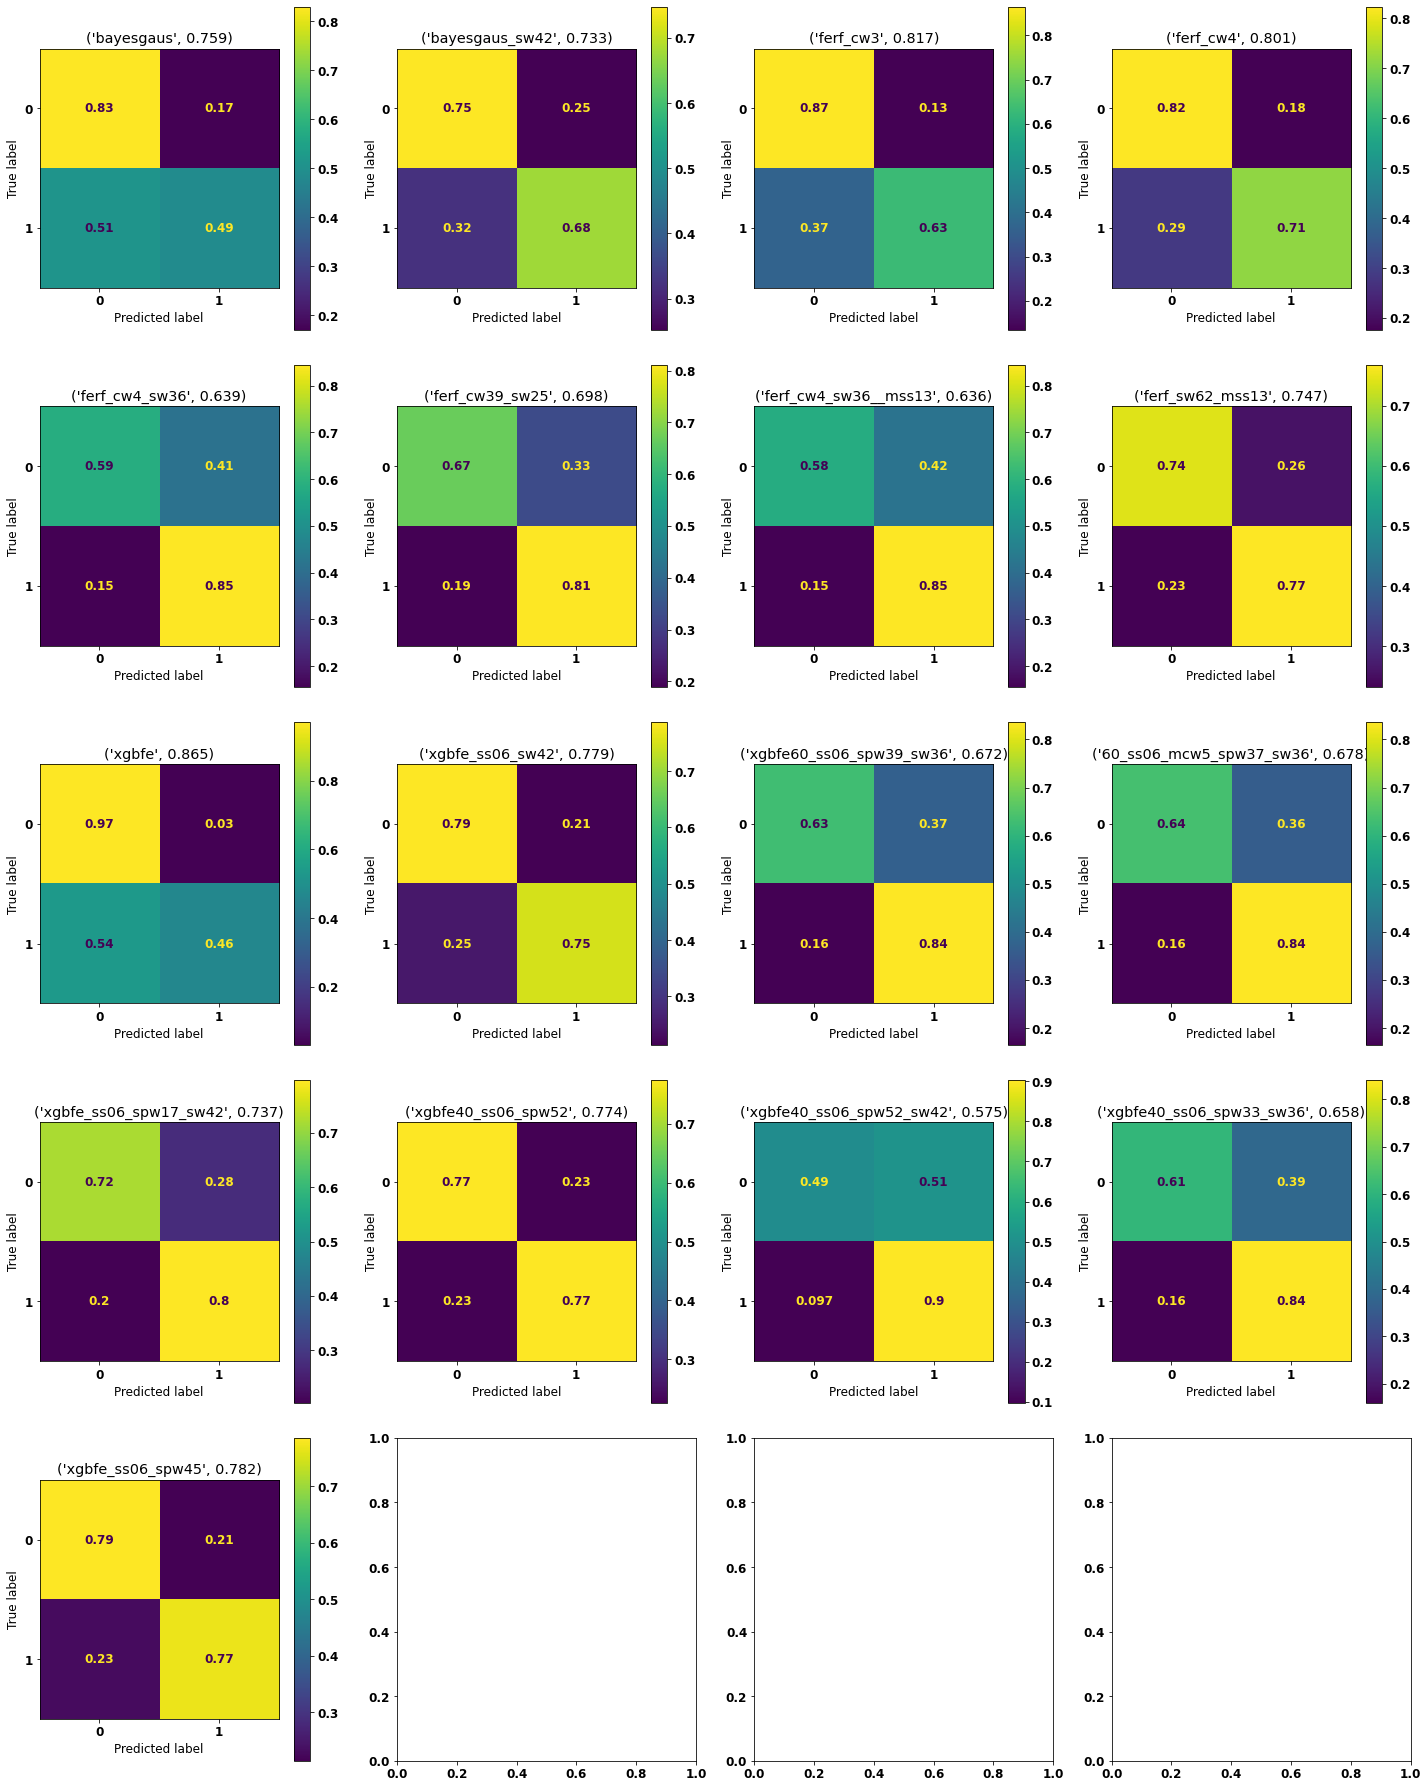

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,25))
for clfname, ax in zip(clfs, axes.flatten()):
  #confusion_matrix_show_test(clfs[clfname])
  pred = clfs[clfname].predict(x_test)
  acc = accuracy_score(y_test, pred)
  plot_confusion_matrix(clfs[clfname], x_test, y_test, labels=[0,1], normalize='true', ax = ax)
  ax.title.set_text((clfname, acc))
plt.tight_layout()  
plt.show()

##Move to the final section with loaded models  
##Plotting roccurves as subplots

In [ ]:
clfs = {'rfgs_cw3':rfgs_cw3, 'rf_cw3_sw42':rf_cw3_sw42, 'rf_cw3':rf_cw3}

In [ ]:
from sklearn.metrics import plot_roc_curve
#svc_disp = plot_roc_curve(rf_cw3_sw42, x_test, y_test)
#plt.show()

In [ ]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

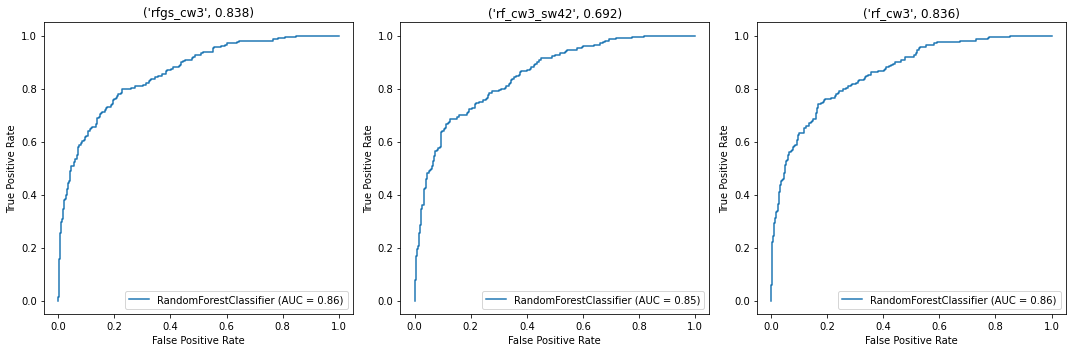

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for clfname, ax in zip(clfs, axes.flatten()):
  #confusion_matrix_show_test(clfs[clfname])
  pred = clfs[clfname].predict(x_test)
  acc = accuracy_score(y_test, pred)
  plot_roc_curve(clfs[clfname], x_test, y_test, ax = ax)
  #plot_confusion_matrix(clfs[clfname], x_test, y_test, labels=[0,1], normalize='true', ax = ax)
  ax.title.set_text((clfname, acc))
plt.tight_layout()  
plt.show()

In [ ]:
#grid search params v.1 + class weight, sample weights
rfgs_cw3_sw42 = RandomForestClassifier(criterion='gini', class_weight = {0:1,1:3}, max_depth=8, max_features=9,
                            max_leaf_nodes=None, max_samples=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=7)
rfgs_cw3_sw42.fit(x_train,y_train,sample_weight=class_weights42)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                       criterion='gini', max_depth=8, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
evaluate_model(rfgs_cw3_sw42)

Test set
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       787
           1       0.41      0.86      0.55       213

    accuracy                           0.71      1000
   macro avg       0.68      0.76      0.67      1000
weighted avg       0.83      0.71      0.73      1000

tn, fp, fn, tp:  523 264 30 183
Val set
              precision    recall  f1-score   support

           0       0.93      0.68      0.78       785
           1       0.41      0.82      0.55       215

    accuracy                           0.71      1000
   macro avg       0.67      0.75      0.67      1000
weighted avg       0.82      0.71      0.73      1000

tn, fp, fn, tp:  530 255 38 177


## TO DELETE Sequential model

In [ ]:
5/13

0.38461538461538464

In [ ]:
def focal_loss(y_true, y_pred):
  gamma = 3#2.0
  alpha = 0.25#0.25
  pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
  pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
  return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [ ]:
#check metrics and losses for binary classification in keras, confusion matrix and class.report fucntions
#https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
#check dtypes of preds and labels
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=17, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # Compile model
    model.compile(optimizer ='adamax', loss = [focal_loss], metrics=[m.TruePositives(thresholds=0.3)])#loss='mse',
                  #metrics =['accuracy'])#, metrics.accuracy(y_test, y_pred)])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                180       
_________________________________________________________________
dense_25 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_26 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 41        
Total params: 1,791
Trainable params: 1,791
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size = 32, epochs = 5, class_weight={0: 1, 1: 5.3})

Epoch 1/5
250/250 [==============================] - 1s 4ms/step - loss: 1.7020 - true_positives_3: 1507.0000 - val_loss: 0.7259 - val_true_positives_3: 163.0000
Epoch 2/5
250/250 [==============================] - 1s 3ms/step - loss: 1.4880 - true_positives_3: 1512.0000 - val_loss: 0.6850 - val_true_positives_3: 167.0000
Epoch 3/5
250/250 [==============================] - 1s 3ms/step - loss: 1.4292 - true_positives_3: 1484.0000 - val_loss: 0.6587 - val_true_positives_3: 167.0000
Epoch 4/5
250/250 [==============================] - 1s 3ms/step - loss: 1.3943 - true_positives_3: 1441.0000 - val_loss: 0.6605 - val_true_positives_3: 168.0000
Epoch 5/5
250/250 [==============================] - 1s 3ms/step - loss: 1.3820 - true_positives_3: 1425.0000 - val_loss: 0.6581 - val_true_positives_3: 168.0000


In [ ]:
#y_pred.shape
#y_pred.argmax(axis=1)
y_test[0:3]

array([0, 0, 0])

In [ ]:
y_pred = model.predict(x_test)
tnt, fpt, fnt, tpt = confusion_matrix(y_test, y_pred.argmax(axis=1)).ravel()
print(tnt, fpt, fnt, tpt)
#metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

818 0 182 0


In [ ]:
preds_t = model.predict(x_test)
preds_v = model.predict(x_val)
print('Test set')
#print(classification_report(y_test, preds_t))
tnt, fpt, fnt, tpt = confusion_matrix(y_test, preds_t)#.ravel()
print(tnt, fpt, fnt, tpt)
print('Val set')
#print(classification_report(y_val, preds_v))
tn, fp, fn, tp = confusion_matrix(y_val, preds_v)#.ravel()
print(tn, fp, fn, tp)

Test set


ValueError: ignored

In [ ]:
def evaluate_model(model_name):
  preds_t = model_name.predict(x_test)
  preds_v = model_name.predict(x_val)
  print('Test set')
  #print(classification_report(y_test, preds_t))
  tnt, fpt, fnt, tpt = confusion_matrix(y_test, preds_t).ravel()
  print(tnt, fpt, fnt, tpt)
  print('Val set')
  #print(classification_report(y_val, preds_v))
  tn, fp, fn, tp = confusion_matrix(y_val, preds_v).ravel()
  print(tn, fp, fn, tp)


In [ ]:
evaluate_model(model)

Test set


ValueError: ignored

## TO DELETE Fast AI tabular learner 

In [ ]:
#Creating train_test and validation sets (plain, with additional features, with additional features and duplicates)
#datatab = data[:8500]
#fedatatab = fe_data[:8500]

#fe_data_dupl = fe_data_with_duplicates[:-1500]
#fe_data_dupl.to_csv(path_cr/'fe_data_dupl.csv', index=False)
#fe_data_duplval = fe_data_with_duplicates[-1500:]
#fe_data_duplval = fe_data_duplval.drop('Exited', axis = 1)
#fe_data_duplval.to_csv(path_cr/'fe_data_duplval.csv', index=False)

#datatabval = data[8500:]
#fedatatabval = fe_data[8500:]
#datatabval = datatabval.drop('Exited', axis = 1)
#fedatatabval = fedatatabval.drop('Exited', axis = 1)
#datatabval.to_csv(path_cr/'datatabval.csv', index=False)
#fedatatabval.to_csv(path_cr/'fedatatabval.csv', index=False)
#datatab.to_csv(path_cr/'datatab.csv', index=False)
#fedatatab.to_csv(path_cr/'fedatatab.csv', index=False)
#saving labels for validation set 
datatabval_labels = data.Exited.values[8500:]
#fedatatabval_labels = fe_data.Exited.values[8500:]
fe_data_duplval_labels = fe_data_with_duplicates.Exited.values[-1500:]


In [ ]:
#Preparing SMOTE dataset for Fastai (concatenating and converting to df)
#bal_test = np.concatenate((bal_smote_x,bal_smote_y.reshape(11138,1)),axis=1)
#s = y_test.shape[0]
#test = np.concatenate((x_test,y_test.reshape(s,1)),axis=1)

In [ ]:
#Adding balanced data to the test dataset
#bal_train_test = np.concatenate((bal_test, test))
#bal_train_test.shape

(1500, 14)

In [ ]:
#Converting to df and saving
#bal_data = pd.DataFrame(data = bal_train_test)
#bal_data = pd.DataFrame(data=bal_data.values, columns=cols)
#bal_data.to_csv(path_cr/'bal_data.csv', index=False)

In [ ]:
#datatab = pd.read_csv(path_cr/'datatab.csv')
fedatatab = pd.read_csv(path_cr/'fedatatab.csv')
#datatabval = pd.read_csv(path_cr/'datatabval.csv')
fedatatabval = pd.read_csv(path_cr/'fedatatabval.csv')
#bal_data = pd.read_csv(path_cr/'bal_data.csv')
fe_data_dupl = pd.read_csv(path_cr/'fe_data_dupl.csv')
fe_data_duplval = pd.read_csv(path_cr/'fe_data_duplval.csv')
print(fe_data_dupl.shape)
print(fe_data_duplval.shape)
#print(bal_data.shape)

(12829, 17)
(1500, 16)


In [ ]:
#Looking for examples with class_weight https://forums.fast.ai/t/class-weight/2883
#Given class 0=no cancer, class 1=cancer, I defined a dictionary:
my_class_weight = {0: 1., 1: 3.}

#Then I was able to use it with fit_generator:
model.fit_generator(…, class_weight=my_class_weight) 

In [ ]:
#Checking that test sets are imbalanced
print(len(fedatatab[-1500:][fedatatab['Exited']==1]))
print(len(fe_data_dupl[-1500:][fe_data_dupl['Exited']==1]))
#fedatatab.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


321

In [ ]:
#Defining dep_var, cat. and cont.columns and other inputs, separating/ opening train/ test and val sets
#cols = fedatatab.columns
dep_var = 'Exited'
cat_vars = ['Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany','Geography_Spain', 'HasCrCard', 'IsActiveMember']
fecat_vars = ['Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany','Geography_Spain', 'HasCrCard', 'IsActiveMember','Age_above45', 'Member_Geo', 'Member_Gender']
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
procs = [Categorify, Normalize]
#procs_bal = [Categorify]
#valid_idx = range(len(datatab)-1500, len(datatab))
valid_idx_fe = range(len(fe_data_dupl)-1500, len(fe_data_dupl))
#valid_idx_bal = range(len(bal_data)-1500, len(bal_data))
#valid_idx = range(len(datatab)-1500, len(datatab-1500))
#valid_idx_bal = range(len(bal_data)-1500, len(bal_data-1500))


In [ ]:
#https://forums.fast.ai/t/f1-score-as-metric/30370/23
#adding fbeta to improve recall (v.2)
class Fbeta_binary(Callback):
    "Computes the fbeta between preds and targets for single-label classification"
    beta2: int = 2
    eps: float = 1e-9
    clas:int=1
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==self.clas) * (y_true==self.clas)).float().sum()
        self.total_y_pred += (y_pred==self.clas).float().sum()
        self.total_y_true += (y_true==self.clas).float().sum()
    
    def on_epoch_end(self, **kwargs):
        beta2=self.beta2**2
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)       
        res = (prec*rec)/(prec*beta2+rec+self.eps)*(1+beta2)
        self.metric = res 

In [ ]:
Fbeta_binary = Fbeta_binary()

In [ ]:
#Adding datasets to databunch
data__ = TabularDataBunch.from_df(path_cr, fe_data_dupl, dep_var, valid_idx=valid_idx_fe, procs=procs, cat_names=fecat_vars, cont_names=cont_vars)

In [ ]:
test = TabularList.from_df(fe_data_duplval, path=path_cr, cat_names=fecat_vars, cont_names=cont_vars)

In [ ]:
data__.add_test(test)

In [ ]:
#v.10 with additional features and duplicates for ones, more epochs
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08,metrics=accuracy)


In [ ]:
#v.9 with additional features and duplicates for ones, more epochs
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08,metrics=accuracy)
learn.fit_one_cycle(7, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.516671,0.460266,0.794000,00:01
1,0.548779,0.458014,0.804667,00:01
2,0.484603,0.404997,0.818000,00:01
3,0.466846,0.435921,0.814000,00:01
4,0.446786,0.420187,0.804667,00:01
5,0.428613,0.416232,0.804000,00:01
6,0.402110,0.424741,0.807333,00:01


In [ ]:
#v.8 with additional features and duplicates for ones
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08,metrics=accuracy)#, loss_func=customlossfunction)
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.534960,0.516685,0.778667,00:03
1,0.504107,0.480179,0.761333,00:02
2,0.500796,0.434955,0.800000,00:03
3,0.454836,0.437747,0.786667,00:02
4,0.429230,0.433084,0.784000,00:02


In [ ]:
#v.7 with fbeta for ones and 3 additional features
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08,metrics=Fbeta_binary)#, loss_func=customlossfunction)
learn.fit_one_cycle(10, 1e-2)

In [ ]:
#v.6 with 3 additional features
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08,metrics=accuracy)#, loss_func=customlossfunction)
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.477649,0.488118,0.797333,00:02
1,0.410115,0.346827,0.856000,00:01
2,0.356598,0.339912,0.860000,00:02


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
#v.5 f1 for ones w/o accuracy
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08,metrics=Fbeta_binary)
#learn.metrics=[Fbeta_binary()]#beta2=1,clas = 1)]
learn.fit_one_cycle(2, 1e-2)

In [ ]:
#v.4 f1 for ones
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08)
#learn.load_encoder('fine_tuned_enc')
learn.metrics=[accuracy, Fbeta_binary()]#beta2=1,clas = 1)]
learn.fit_one_cycle(2, 1e-2)

In [ ]:
#v.3 with fbeta
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08)
learn.metrics = [accuracy,fbeta_binary]
learn.fit_one_cycle(2, 1e-2)

In [ ]:
#v.2
learn = tabular_learner(data__, layers=[1000,500], emb_drop=0.08, metrics=accuracy)
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.479388,0.512784,0.820000,00:02
1,0.397409,0.344302,0.858667,00:01
2,0.358227,0.336587,0.864667,00:01


In [ ]:
??get_preds